# **ASSIGNEMENT 1**

**We first install all the required libraries**

In [56]:
# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Handling Imbalanced Data 
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Jupyter Notebook Configuration
%matplotlib inline
sns.set_style("darkgrid")


-----

### **TASK 1: DATA LOADING AND INITIAL EXPLORATION**

**Import the dataset from excel**

In [2]:
df = pd.read_excel("titanic3.xls")

# Display the first few rows to make sure the excel was readed correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


• Now we are going to perform some purely statistical operations to understand better the entity of the dataset, including outliers, missing data, etc.

In [3]:
df.head()  

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
df.describe() 

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [5]:
df.isnull().sum() # Check how many values are missing

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

• Let's understand what percentage of people actually survived by seeing it visually

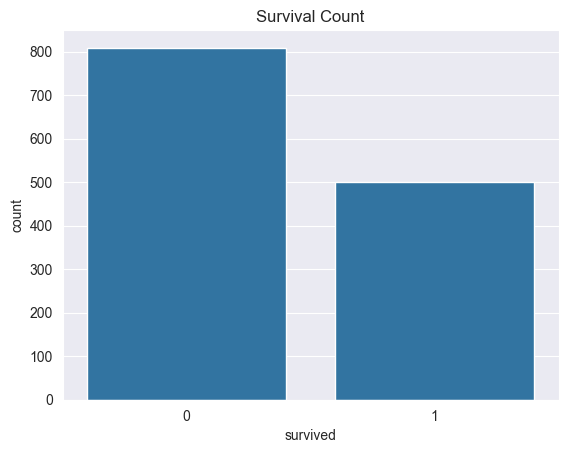

In [6]:
sns.countplot(x="survived", data=df)
plt.title("Survival Count")
plt.show()

In [7]:
# Count duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 0


• Let's now see the age distribution

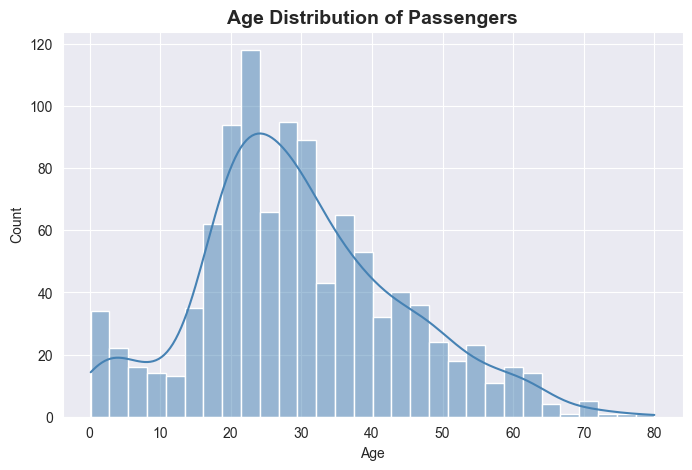

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(df["age"], bins=30, kde=True, color="steelblue")
plt.title("Age Distribution of Passengers", fontsize=14, fontweight="bold")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


• Now let's see if there are any correlation between different classes of the dataset

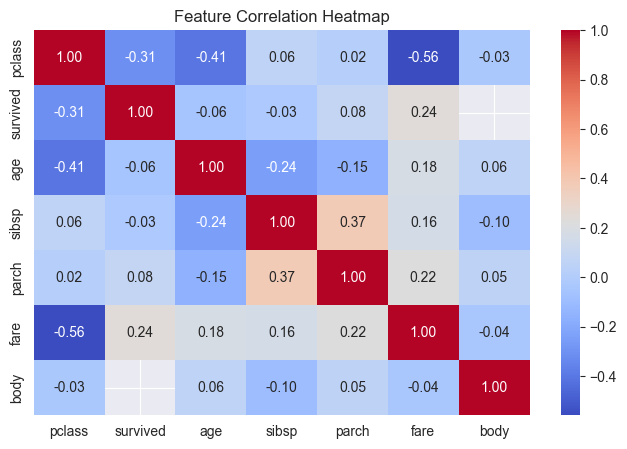

In [9]:
plt.figure(figsize=(8,5))

# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])

# Create the heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Feature Correlation Heatmap")
plt.show()


From this we can derive different intuitions which for now I think are the most relevant information:

- There is a strong negative correlation (-0.56) between the fare and the class of the passenger. This makes perfectly sense since the higher the class ( 1st, 2nd, 3rd...), the less you pay.

- There is a moderate positive correlation (0.37) between the people who have siblings/spouses and the people who have parents/children, which again makes perfectly sense.

- There is one last notable correlation, the one between the fare and the people that survived, which is positive (0.24). From here we can deduce that the people that payed more, so the people that were in higher classes were more likely to survive.

------

### **TASK 2: MANAGING MISSING VALUES**

As we saw earlier, there are several missing values, and we have to deal with them. 
Let's see the data again:

In [10]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In order to handle this missing values, we have to take different approach for each of the columns:
- **Age**: This is an important factor when determing whether a person survives or not. To fill in the missing values we will be using median imputation. We use this instead of the mean to rule out outliers such as very old people and very young people.

- **Fare**: Only one value is missing so we will just fill that with the median again.

- **Cabin**: The vast majority of it is missing, however this is a really important feature since the higher blocks (A, B and C) had easier access to boats while lower ones (D, E, F and so on) were further and had a harder time escaping. For this reason we are going to drop the number of the cabins and just keep the letter of the block (for example C85-->C), and since we cannot assign random rooms to the missing people we are just going to assign the letter U for Unknown.

- **Embarked**: This is a categorical value and only 2 are missing so we are going to use the mode and assign to them the most common value. We are going to keep the data since we don't know whether this is significant or not.

- **Boat**: A lot of these are missing, furthermore, having or not having a assigned boat it is too closely linked to survival. In addition, passengers were not assigned or not a boat in advance, the decision was taken in that precise moment (favoring women, children, elderly, ecc...). That is why is wise to drop this column. However we first have to prove our point.

- **Body**: Since this data is taken after the disaster and has nothing to do with the prediction, we can drop this column.

- **Destination**: Roughly half is missing, and since we don't know if is relevant or not we are just going to assign U for Unknown to the missing ones.

- **Name**: Even though we do not have missing values, we are going to drop the name column since is irrelevant for prediction, occupies space and increases computational time 

In [11]:
# Age & Fare: Use median imputation
df['age'].fillna(df['age'].median(), inplace=True)
df['fare'].fillna(df['fare'].median(), inplace=True)

# Fill missing embarked values with the most common value
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)

# Drop the 'body' and 'name' column
df.drop(columns=['body'], inplace=True)
df.drop(columns=['name'], inplace=True)

# Process 'cabin' - Extract first letter and fill missing values
df['cabin'] = df['cabin'].astype(str).str[0]  # Keep only the first letter
df['cabin'].fillna("U", inplace=True)  # "U" for Unknown cabins

# Home.dest: Fill missing values with "Unknown"
df['home.dest'].fillna("Unknown", inplace=True)

/var/folders/6t/x352pljx1sb92hc4wdpsg_fm0000gn/T/ipykernel_4369/3613836495.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
/var/folders/6t/x352pljx1sb92hc4wdpsg_fm0000gn/T/ipykernel_4369/3613836495.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

Checking now if the correlation between having a boat and surviving is too high:

In [12]:
# We are creating a new column called "boat_assigned" that will be 1 if the passenger was assigned a boat and 0 if not
df['boat_assigned'] = df['boat'].notna().astype(int)

# Check how strongly 'boat_assigned' is related to 'survived'
correlation = df['boat_assigned'].corr(df['survived'])
print(f"Correlation between boat_assigned and survived: {correlation}")

Correlation between boat_assigned and survived: 0.9481900695821412


This is definitely too high. The model would rely too much on this. We have to drop it

In [13]:
# Drop the 'boat' column
df.drop(columns=['boat_assigned'], inplace=True)
df.drop(columns=['boat'], inplace=True)

Let's now check if it worked correctly by checking again the missing values and the heatmap:

In [14]:
df.isnull().sum()

pclass       0
survived     0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
home.dest    0
dtype: int64

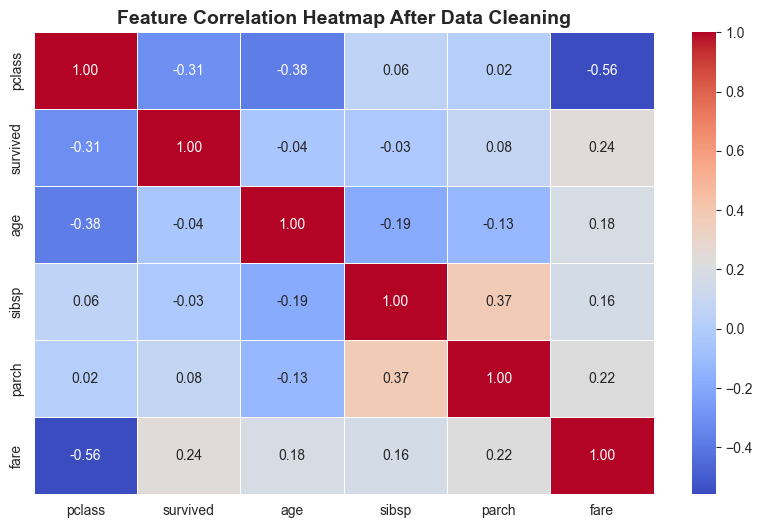

In [15]:

numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap After Data Cleaning", fontsize=14, fontweight="bold")
plt.show()

Everything seemed to work well. We can move on.

------

### **TASK 3: ENCODING CATEGORICAL VARIABLES**

The first step to do this is first of all identify what categorical variables do we have. These are: Sex, Embarked, Cabin and Home.dest. The first 3 are fine, however, regarding Home.dest, we have a problem and is that since when we encode with OneHotEncoder we make the database larger since we are separating each category and making it a vecor, when we have many options, even though they are finite, it could overload the dataset. For this reason we are going to esclude to encode Home.dest.
To avoid this problem also with the first three variables, we are going to drop the first type, to avoid redundancy and minimize the used space. This is because for example with sex, if you are not a male you can only be a female (maybe nowadays someone would say otherwise but we will exclude that in our case!!), so there is no point of having a column for both. Let's just make it for that one and if you are not one you are the other.

In [16]:
df.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,female,29.0000,0,0,24160,211.3375,B,S,"St Louis, MO"
1,1,1,male,0.9167,1,2,113781,151.5500,C,S,"Montreal, PQ / Chesterville, ON"
2,1,0,female,2.0000,1,2,113781,151.5500,C,S,"Montreal, PQ / Chesterville, ON"
3,1,0,male,30.0000,1,2,113781,151.5500,C,S,"Montreal, PQ / Chesterville, ON"
4,1,0,female,25.0000,1,2,113781,151.5500,C,S,"Montreal, PQ / Chesterville, ON"


In [17]:

categorical_cols = ["sex", "embarked", "cabin"]


encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' avoids redundancy


encoded_array = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the new encoded columns with the original dataset
df = pd.concat([df, encoded_df], axis=1)

# Drop the original categorical columns (we now have their numerical representations)
df.drop(columns=categorical_cols, inplace=True)


df.head()

,pclass,survived,age,sibsp,parch,ticket,fare,home.dest,sex_male,embarked_Q,embarked_S,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_n
0,1,1,29.0000,0,0,24160,211.3375,"St Louis, MO",0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.9167,1,2,113781,151.5500,"Montreal, PQ / Chesterville, ON",1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,2.0000,1,2,113781,151.5500,"Montreal, PQ / Chesterville, ON",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,30.0000,1,2,113781,151.5500,"Montreal, PQ / Chesterville, ON",1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,25.0000,1,2,113781,151.5500,"Montreal, PQ / Chesterville, ON",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


However, since there is only one person that has the cabin 'T', we are going to drop that column.

In [18]:
df.drop(columns=['cabin_T'], inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   int64  
 1   survived    1309 non-null   int64  
 2   age         1309 non-null   float64
 3   sibsp       1309 non-null   int64  
 4   parch       1309 non-null   int64  
 5   ticket      1309 non-null   object 
 6   fare        1309 non-null   float64
 7   home.dest   1309 non-null   object 
 8   sex_male    1309 non-null   float64
 9   embarked_Q  1309 non-null   float64
 10  embarked_S  1309 non-null   float64
 11  cabin_B     1309 non-null   float64
 12  cabin_C     1309 non-null   float64
 13  cabin_D     1309 non-null   float64
 14  cabin_E     1309 non-null   float64
 15  cabin_F     1309 non-null   float64
 16  cabin_G     1309 non-null   float64
 17  cabin_n     1309 non-null   float64
dtypes: float64(12), int64(4), object(2)
memory usage: 184.2+ KB


As we can see, OneHotEncoder dropped 'sex_female', 'embarked_C', 'cabin_A' and changed the name Unknown for cabins to cabin_n.

Now our categorical variables are encoded. We can now proceed.

-----

### **TASK 4: FEATURE SCALING**

Standardization scales data to have mean = 0 and standard deviation = 1, making it useful for models that assume normally distributed data, and it generally preserving outliers. Normalization rescales data to [0,1], which compresses extreme values. In this work, standardization ensures fair comparisons between variables, while normalization prevents some features from dominating due to larger scales. Since we are dealing with mixed data types, we did both of them and we will see which one to use for each different task in the future.

In [20]:

num_cols = ["age", "sibsp", "parch", "fare", "pclass"]  


std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply Standardization 
df_standardized = df.copy()
df_standardized[num_cols] = std_scaler.fit_transform(df[num_cols])

# Apply Normalization 
df_normalized = df.copy()
df_normalized[num_cols] = minmax_scaler.fit_transform(df[num_cols])


print("Standardized Data:")
print(df_standardized.head())

print("\nNormalized Data:")
print(df_normalized.head())


Standardized Data:
     pclass  survived       age     sibsp     parch  ticket      fare  \
0 -1.546098         1 -0.039005 -0.479087 -0.445000   24160  3.442584   
1 -1.546098         1 -2.215952  0.481288  1.866526  113781  2.286639   
2 -1.546098         0 -2.131977  0.481288  1.866526  113781  2.286639   
3 -1.546098         0  0.038512  0.481288  1.866526  113781  2.286639   
4 -1.546098         0 -0.349075  0.481288  1.866526  113781  2.286639   

                         home.dest  sex_male  embarked_Q  embarked_S  cabin_B  \
0                     St Louis, MO       0.0         0.0         1.0      1.0   
1  Montreal, PQ / Chesterville, ON       1.0         0.0         1.0      0.0   
2  Montreal, PQ / Chesterville, ON       0.0         0.0         1.0      0.0   
3  Montreal, PQ / Chesterville, ON       1.0         0.0         1.0      0.0   
4  Montreal, PQ / Chesterville, ON       0.0         0.0         1.0      0.0   

   cabin_C  cabin_D  cabin_E  cabin_F  cabin_G  cabin_n

------

### **TASK 5: DATA SPLITTING**

We splitted the dataset so that we have:
- 80% Training set
- 10% Validation set
- 10% Test set
We chose this division since our dataset is relativli really small (1300 aprox).
We also made sure that it mantained the same percentage of target value (survived) in each of the subsets, thanks to stratification

In [21]:
# Define target variable
target = "survived"

# First, divide between training and a temporary set (which will be later split into validation and test)
df_train, df_temp = train_test_split(df, test_size=0.2, stratify=df[target], random_state=42)


df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp[target], random_state=42)

# Extract features (X) and target (y) for training
X_train = df_train.select_dtypes(include=['number']).drop(columns=[target])
y_train = df_train[target]

X_val = df_val.select_dtypes(include=['number']).drop(columns=[target])
y_val = df_val[target]

X_test = df_test.select_dtypes(include=['number']).drop(columns=[target])
y_test = df_test[target]


print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 1047
Validation set size: 131
Test set size: 131


---

### **TASK 6: ADDRESSING CLASS IMBALANCE**

I tried in different ways to create scatterplots in order to visualize the imbalances but I was not able to select the right axis in order to have meaningful results

Let's apply SMOTE and ADASYN to address imbalances in the data within the training set.

In [22]:
# Show class distribution before resampling
unique_before, counts_before = np.unique(y_train, return_counts=True)
print("Class distribution before resampling:", dict(zip(unique_before, counts_before)))

# SMOTE
X_train_resampled_smote, y_train_resampled_smote = SMOTE().fit_resample(X_train, y_train)

# ADASYN
X_train_resampled_adasyn, y_train_resampled_adasyn = ADASYN().fit_resample(X_train, y_train)

# Show class distribution after SMOTE
unique_smote, counts_smote = np.unique(y_train_resampled_smote, return_counts=True)
print("Class distribution after SMOTE:", dict(zip(unique_smote, counts_smote)))

# Show class distribution after ADASYN
unique_adasyn, counts_adasyn = np.unique(y_train_resampled_adasyn, return_counts=True)
print("Class distribution after ADASYN:", dict(zip(unique_adasyn, counts_adasyn)))


Class distribution before resampling: {np.int64(0): np.int64(647), np.int64(1): np.int64(400)}
Class distribution after SMOTE: {np.int64(0): np.int64(647), np.int64(1): np.int64(647)}
Class distribution after ADASYN: {np.int64(0): np.int64(647), np.int64(1): np.int64(582)}


From the results we can clearly see that:
- Before resampling, we had (in the training set) 647 people did not survive and 400 survived. 
- After SMOTE, we have 647 did not survive and 647 survived.
- After ADASYN, we have 647 did not survive and 582 survived.

Our code generated synthetic examples to help the model train in struggling areas. 

---

### **TASK 7: FEATURE SELECTION**

We are going to remove low variance features and highly correlated features for two different reasons:

- Low variance features: This is because they provide little or no useful information to the model
- Highly correlated features: This can lead to bias in the model when training. And is also the reason why we manually dropped the 'boat_assigned' column previously.

In [23]:

var_thresh = VarianceThreshold(threshold=0.01)  # Features with variance < 0.01 are removed

X_train_filtered = var_thresh.fit_transform(X_train)

selected_features = X_train.columns[var_thresh.get_support()]
X_train_filtered = pd.DataFrame(X_train_filtered, columns=selected_features)

corr_matrix = X_train_filtered.corr().abs()

# Find highly correlated features
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop highly correlated features
X_train_final = X_train_filtered.drop(columns=to_drop)


print(f"Removed low-variance features: {set(X_train.columns) - set(selected_features)}")
print(f"Removed highly correlated features: {to_drop}")
print(f"Final feature set: {X_train_final.columns.tolist()}")

Removed low-variance features: {'cabin_G'}
Removed highly correlated features: []
Final feature set: ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q', 'embarked_S', 'cabin_B', 'cabin_C', 'cabin_D', 'cabin_E', 'cabin_F', 'cabin_n']


After running the code we can see that the only column affected was 'cabin_G' because its variance was smaller than 0.01 across the whole dataset.

However, we performed this operations after splitting the data between training, validation and test for several reasons. 
If we performed this operation on the whole dataset, and then we split it, we would train the whole model on too optimistic situations, and it wouldn't be able to actually predict real world scenarios. That is also the same reason why we did the SMOTE and ADASYN after splitting: we would train the model in a way that it wouldn't reflect real-world class distributions.
Performing these tasks post-split maintains the integrity of the validation and test sets, ensuring unbiased performance evaluation.

---

### **TASK 8: TRAINING A LOGISTIC REGRESSION MODEL**

We will train the model hoping to get a regression accuracy of approximately 0.82 (as overheard the professor saying in class (:   )

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled_smote)  # Using SMOTE resampled data
X_val_scaled = scaler.transform(X_val)
y_train_resampled = y_train_resampled_smote 

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train_resampled)

# Predict on validation set
y_val_pred = model.predict(X_val_scaled)

# Accurancy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Logistic Regression Accuracy on Validation Set: {accuracy:.4f}")

Logistic Regression Accuracy on Validation Set: 0.7710


Since the results where not fantastic I tried somethig different and the results are very interesting.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train logistic regression without resampling
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
y_val_pred = model.predict(X_val_scaled)


print("Accuracy without resampling:", accuracy_score(y_val, y_val_pred))


Accuracy without resampling: 0.8091603053435115


This may be due to the fact that both SMOTE and ADASYN created some sort of oversampling in the data or maybe they introducted too much noise with the synthetic samples.

I decided to visualize the predicted data in 3 ways:
- ROC Curve
- Confusion Matrix
- Scatter Plot

I think the most visually stimulating and easier to understand is the Scatter Plot, we will se now why

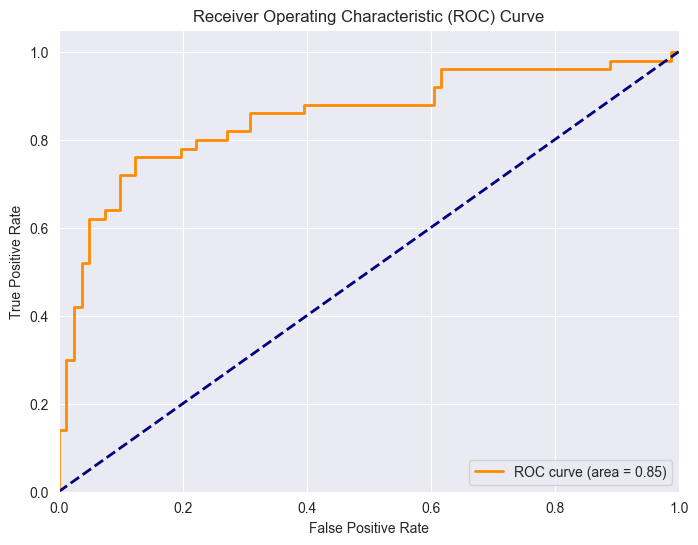

In [ ]:
y_val_prob = model.predict_proba(X_val_scaled)[:, 1]  # Probabilities for the positive class (survived)
y_val_pred = model.predict(X_val_scaled) 

# Assuming y_val contains true labels and y_val_prob contains predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


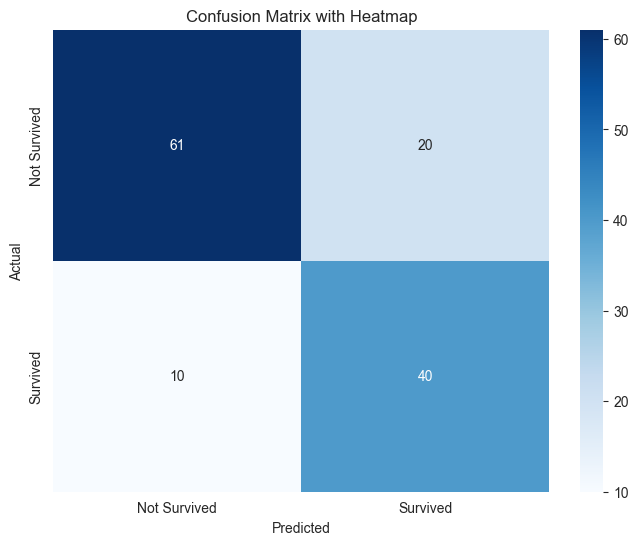

In [60]:
# Assuming y_val contains true labels and y_val_pred contains predictions
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Heatmap')
plt.show()


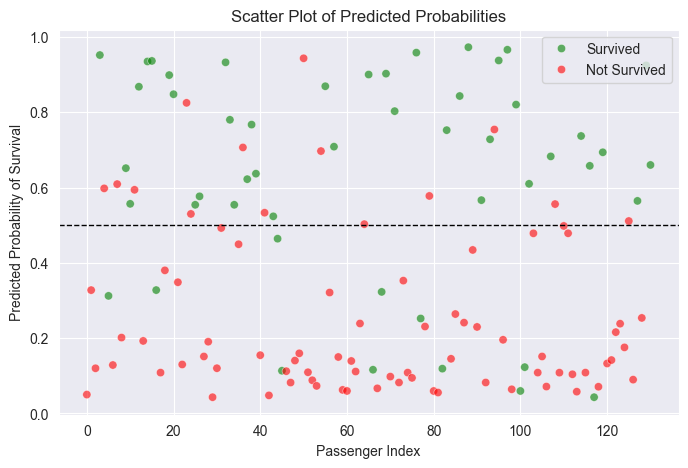

In [70]:
# Get predicted probabilities for the positive class (Survived = 1)
y_val_prob = model.predict_proba(X_val_scaled)[:, 1]


plt.figure(figsize=(8, 5))
sns.scatterplot(x=np.arange(len(y_val_prob)), y=y_val_prob, hue=y_val, 
                palette={0: "red", 1: "green"}, alpha=0.6)


plt.axhline(0.5, color='black', linestyle='--', linewidth=1)  # Decision threshold at 0.5
plt.xlabel("Passenger Index")
plt.ylabel("Predicted Probability of Survival")
plt.title("Scatter Plot of Predicted Probabilities")


handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=[handles[1], handles[0]], labels=["Survived", "Not Survived"])

plt.show()


As we can see from this last graph, but also from the two previous ones, we can easily visualize the people that had the higher probability of surviving and those who had the lower probability. 

On top of that the people that actually survived and the ones who didn't.